# Library

In [1]:
import math
import dill
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import squigglepy as sq
import datetime as dt

from squigglepy import bayes
from squigglepy.numbers import K, M, B, T
from copy import deepcopy
from scipy import stats
from pprint import pprint
from collections import Counter
from tqdm import tqdm

%matplotlib inline
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

Loaded 1
Loaded 2


In [2]:
VARS = {}

# Global variables - probably don't want to change these but you could.
VARS['RUNS'] = 10*K                                      # Number of runs to do (default 100*K)
VARS['CURRENT_YEAR'] = 2023                              # What year to start the run on? (default: 2023)
VARS['MAX_YEAR'] = 2123                                  # What year to end the run on? (default: 2123)

CURRENT_YEAR = VARS['CURRENT_YEAR']
years = range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR'])
print('Loaded')


Loaded


# Model

### TAI Scenarios

In [3]:
# Conditional on making agentic TAI, will it be aligned by default?
VARS['p_tai_aligned_by_default'] = 0.3

# Conditional on making agentic TAI that is not aligned by default, will we solve the alignment problem?
# Varies by year, whether this is the first attempt, and whether there is a great power war
def p_alignment_solved(year, first_attempt=True, verbose=False):
    if first_attempt:
        p = min(2.2 * (year/45), 0.8)
    else:
        p = min(2.8 * (year/45), 0.9)
    if verbose == 2:
        print('* alignment solve diagnostic - war: {} year: {} first attempt: {} -> p {})'.format(war, year, first_attempt, p))
    return p
VARS['p_alignment_solved'] = p_alignment_solved
# TODO: Convert to logistic curves


# Conditional on making agentic TAI that is not aligned by default, will we successfully coordinate to deploy safe AI?
# Varies by year, whether this is the first attempt, and whether there is a great power war
def p_alignment_deployment_safety_and_coordination(year, war, variables, first_attempt=True, verbose=False):
    if year <= 2030 - variables['CURRENT_YEAR'] and not war:
        p = 0.8
    elif war:
        p = 0.4
    else:
        p = 0.6
    if first_attempt is False:
        p += 0.1
    p = min(p, 0.95)
    p = max(p, 0.05)
    if verbose == 2:
        print('* alignment coordination diagnostic - war: {} year: {} first attempt: {} -> p {})'.format(war, year, first_attempt, p))
    return p
VARS['p_alignment_deploy_coordination'] = p_alignment_deployment_safety_and_coordination

# Conditional on solving the alignment problem, what is the chance we also solve the subtle misalignment problem?
VARS['p_subtle_alignment_solved'] = 0.85

# Conditional on alignment by default, what is the chance we also solve the subtle misalignment problem?
VARS['p_subtle_alignment_solved_if_aligned_by_default'] = 0.4

# Conditional on having aligned AI, will we know it is aligned and therefore want to deploy it?
VARS['p_know_aligned_ai_is_aligned'] = 0.6

# Conditional on having misaligned AI, will we know it is misaligned and therefore not want to deploy it?
VARS['p_know_misaligned_ai_is_misaligned'] = 0.7

# Conditional on having agentic TAI, will it be intentionally misused to create a singleton?
def p_tai_intentional_misuse(war):
    return 0.2 if war else 0.02
VARS['p_tai_intentional_misuse'] = p_tai_intentional_misuse

# If TAI is fully misaligned what is the chance we can successfully detect and avert this?
VARS['p_full_tai_misalignment_averted'] = 0.2

# If TAI is fully misaligned but successfully averted, what is the probability there will be a catasrophe (10%+ death)?
VARS['p_tai_misalignment_averting_is_catastrophic'] = 0.4

# If TAI is fully misaligned and we successfully avert it, what is the chance we give up on TAI?
VARS['p_full_tai_misalignment_averted_means_abandoned_tai'] = 0.7

# If TAI is fully misaligned, what is the chance it results in extinction versus a singleton?
VARS['p_tai_xrisk_is_extinction'] = 0.1

# If there is a fully misaligned TAI singleton, what is the chance it results in a non-extinction catastrophe (10%+ death)?
VARS['p_tai_singleton_is_catastrophic'] = 0.8

# If ther is an intentional attempt to misuse TAI to create a singleton, what is the chance it causes extinction instead?
VARS['p_intentional_tai_singleton_creates_extinction'] = 0.05


exec(open('modules/tai_risk.py').read())
print('Loaded TAI scenarios module')


Loaded TAI scenarios module


In [4]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

VARS['delay'] = delay
print('Loaded')
delay

Loaded


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(mean=1.39, sd=0.42)
   - 0.1 weight on <Distribution> lognorm(mean=2.25, sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(mean=1.04, sd=0.63)
   - 0.1 weight on <Distribution> lognorm(mean=1.7, sd=0.37)},
 'robotics': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.85 weight on <Distribution> lognorm(mean=1.7, sd=0.37)
   - 0.15 weight on <Distribution> lognorm(mean=2.33, sd=0.23)},
 'integration': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(mean=2.25, sd=0.7)},
 'real_world_feedback': {'prob': 

In [5]:
# Defined in "(1) Anchors"
#
# set `threat_models = None` to not use this feature
#
with open('caches/threat_models.dill', 'rb') as f:
    threat_models = dill.load(f)

VARS['threat_model'] = threat_models
print('Loaded')

Loaded


### Nuclear Scenarios Module

In [6]:
# Annual chance Russia uses a nuke
def p_russia_uses_nuke(peace, year, variables):
    peace = 10 if peace else 1
    year = year + variables['CURRENT_YEAR']
    if year == 2023:
        return 0.03
    else:
        return 0.001 / peace
VARS['p_russia_uses_nuke'] = p_russia_uses_nuke


# Annual chance North Korea uses a nuke
VARS['p_nk_uses_nuke'] = 0.001


# Annual chance China invades Taiwan
def p_china_invades_taiwan(peace, year, variables):
    peace = 10 if peace else 1
    year = year + variables['CURRENT_YEAR']
    if year == 2022:
        return 0
    elif year == 2023:
        return 0.01
    elif year == 2024 or year == 2025:
        return 0.0255   # makes cumulative probability by EOY 2025 = 0.06
                        # solve 0.01 + (1-0.01)*X + (1-0.01)(1-X)*X = 0.06, 0>X<1
    elif year < 2030:
        return 0.0493 # makes cumulative probability by EOY 2029 = 0.27
                      # solve 0.06 + (1-0.06)*X + (1-0.06)(1-X)*X + (1-0.06)(1-X)^2*X + (1-0.06)(1-X)^3*X + (1-0.06)(1-X)^4*X = 0.27
    elif year < 2035:
        return 0.0352 # makes cumulative probability by EOY 2034 = 0.39
                      # 0.27 + (1-0.27)*X + (1-0.27)(1-X)*X + (1-0.27)(1-X)^2*X + (1-0.27)(1-X)^3*X + (1-0.27)(1-X)^4*X = 0.39
    else:
        return 0.005 / peace
VARS['p_china_invades_taiwan'] = p_china_invades_taiwan


# Annual chance China uses a nuke
def p_china_uses_nuke(peace, year, variables):
    return VARS['p_china_invades_taiwan'](peace, year, variables) * 0.01
VARS['p_china_uses_nuke'] = p_china_uses_nuke

    
# Annual chance another country uses a nuke
def p_other_uses_nuke(peace):
    peace = 10 if peace else 1
    return 0.0002 / peace
VARS['p_other_uses_nuke'] = p_other_uses_nuke


# What is the chance in a given year there will be a "nuclear accident"?
def p_nuclear_accident(war, year):
    p = 0.05 if war else 0.02
    p = p * (0.998 ** year)
    return p
VARS['p_nuclear_accident'] = p_nuclear_accident


# Conditional on a nuclear accident, what is the chance it escalates into an "exchange"?
def p_nuclear_accident_becomes_exchange(war):
    return 0.2 if war else 0.05
VARS['p_nuclear_accident_becomes_exchange'] = p_nuclear_accident_becomes_exchange


# Conditional on a nuclear exchange, what is the chance it escalates into a catastrophe (10%+ dead)?
def p_catastrophe_from_nuclear_exchange(war):
    p_exchange_becomes_all_out_war = 0.6 if war else 0.3
    p_nuclear_winter_happens = 0.3
    alternative_foods_or_other_save = 0.05
    return (p_exchange_becomes_all_out_war *
            (p_nuclear_winter_happens + (1 - p_nuclear_winter_happens) * 0.1) *
            (1 - alternative_foods_or_other_save))
VARS['p_catastrophe_from_nuclear_exchange'] = p_catastrophe_from_nuclear_exchange

    
# Conditional on a nuclear exchange catastrophe, what is the chance it becomes an xrisk?
VARS['p_xrisk_from_nuclear_catastrophe'] = 0.05 # https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would


# Conditional on a great power war, what is the chance it goes intentionally nuclear in any given year?
def p_nuclear_exchange_given_war(first_year_of_war):
    return 0.1 if first_year_of_war else 0.02
VARS['p_nuclear_exchange_given_war'] = p_nuclear_exchange_given_war


exec(open('modules/nuclear.py').read())
print('Loaded nuclear scenarios module')


Loaded nuclear scenarios module


### Great Power War Scenarios Module

In [7]:
# Annual chance that, conditional on Russia not nuking outside of a great power war, there will be a US-Russia great power war
def p_great_power_war_us_russia_without_nuke_first(peace, year, variables):
    peace = 20 if peace else 1
    year = year + variables['CURRENT_YEAR']
    if year <= 2025:
        return (0.01 / 2) / peace
    else:
        return 0.002 / peace
VARS['p_great_power_war_us_russia_without_nuke_first'] = p_great_power_war_us_russia_without_nuke_first
    
    
# Annual chance that there is a great power war between the US and China
def p_great_power_war_us_china(peace, year, variables):
    p_invade_taiwan = variables['p_china_invades_taiwan'](peace, year, variables)
    p_us_responds = 0.6
    return p_invade_taiwan * p_us_responds
VARS['p_great_power_war_us_china'] = p_great_power_war_us_china

    
# Annual chance that there is some great power war other than US<>Russia and US<>China
def p_great_power_war_other(peace, year, variables):
    peace = 5 if peace else 1
    year = year + variables['CURRENT_YEAR']
    if year > 2040:
        return 0.003 / peace
    else:
        return 0.0005 / peace
VARS['p_great_power_war_other'] = p_great_power_war_other


# Conditional on a great power war starting, how long will it last?
VARS['war_length'] = sq.lognorm(2, 50) # 90% CI

# After a war ends, how long will there be a peace?
VARS['peace_length'] = sq.lognorm(10, 100)


exec(open('modules/great_power_war.py').read())
print('Loaded great power war scenarios module')


Loaded great power war scenarios module


### Bio scenarios module

In [8]:
# Conditional on a great power war, what is the annual chance it intentionally results in a bioweapon?
VARS['p_biowar_given_war'] = 1/800

# What is the annual chance of a non-state actor creating an intentional biorisk that causes 1%+ death?
VARS['p_nonstate_bio'] = 1/600

# What is the chance that if 1%+ die from natural bio, 10%+ will die from natural bio?
VARS['p_natural_bio_is_catastrophe'] = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# What is the chance that if 1%+ die from engineered bio, 10%+ will die from engineered bio?
VARS['p_engineered_bio_is_catastrophe'] = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

VARS['p_covid_spanish_flu_like_becomes_1pct_death'] = 1 / (10 ** 0.5) # https://www.economist.com/graphic-detail/coronavirus-excess-deaths-estimates suggests COVID killed 0.2%... https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028 suggests 1% is 2x less likely than 0.2%
VARS['p_covid_lab_leak'] = 0.1
VARS['p_extinction_given_90_pct_death'] = 0.03 # per Luisa https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would
VARS['p_accidental_catastrophe_causes_90_pct_death'] = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028
VARS['p_intentional_catastrophe_causes_90_pct_death'] = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# If a lab leak occurs, how likely is it that the leaked pandemic will be engineered vs. natural?
VARS['ratio_engineered_vs_natural_lab_leak'] = 0.8

# What is the chance of an natural biorisk/pandemic causing 1%+ population death?
def p_natural_bio(year, variables):
    base_rate_from_covid_and_spanish_flu = 1/250
    increase_from_globalization = 1.1
    decreate_in_rate_per_year_from_improvements = 0.99 ** year
    return ((base_rate_from_covid_and_spanish_flu * 0.5 +
             base_rate_from_covid_and_spanish_flu * (1 - variables['p_covid_lab_leak']) * 0.5) *
            increase_from_globalization *
            variables['p_covid_spanish_flu_like_becomes_1pct_death'] *
            decreate_in_rate_per_year_from_improvements)
VARS['p_natural_bio'] = p_natural_bio
    
    
# What is the chance of an accidental biorisk (e.g., lab leak) causing 1%+ population death?
def p_accidental_bio(war, variables):
    base_rate_from_covid = 0.01 * variables['p_covid_lab_leak']
    increase_factor_due_to_increasing_labs = 1.3
    increase_factor_due_to_great_power_war = 2
    p = (base_rate_from_covid *
         variables['p_covid_spanish_flu_like_becomes_1pct_death'] *
         increase_factor_due_to_increasing_labs)
    return p * increase_factor_due_to_great_power_war if war else p
VARS['p_accidental_bio'] = p_accidental_bio    


# Conditional on a accidental biorisk (1% death), what is the chance it becomes a xrisk?
def p_xrisk_from_accidental_bio_given_catastrophe(year, variables):
    return variables['p_accidental_catastrophe_causes_90_pct_death'] * variables['p_extinction_given_90_pct_death']
VARS['p_xrisk_from_accidental_bio_given_catastrophe'] = p_xrisk_from_accidental_bio_given_catastrophe


# Conditional on a bioweapon, what is the chance it becomes a xrisk?
def p_xrisk_from_engineered_bio_given_catastrophe(year, variables):
    return variables['p_intentional_catastrophe_causes_90_pct_death'] * variables['p_extinction_given_90_pct_death']
VARS['p_xrisk_from_engineered_bio_given_catastrophe'] = p_xrisk_from_engineered_bio_given_catastrophe


exec(open('modules/bio.py').read())
print('Loaded bio scenarios module')


Loaded bio scenarios module


### Nanotech scenarios module

In [9]:
# What is the chance in a given year that nanotech will be developed?
def p_nanotech_possible(year):
    return 0.0001 / (0.956 ** year) # TODO: This goes over 1
VARS['p_nanotech_possible'] = p_nanotech_possible


# Conditional on developing nanotech, what is the chance nanotech results in an xrisk?
VARS['p_nanotech_is_xrisk'] = 0.1 * 0.05


exec(open('modules/nano.py').read())
print('Loaded nano scenarios module')


Loaded nano scenarios module


### Supervolcano scenarios module (all other natural risks <0.01%)

In [10]:
VARS['p_supervolcano_catastrophe'] = 1 / (500*K)  # https://www.openphilanthropy.org/research/large-volcanic-eruptions/ VEI >= 9 (geometric mean of 30K and 30M)

VARS['p_supervolcano_extinction_given_catastrophe'] = 0.05


exec(open('modules/supervolcano.py').read())
print('Loaded supervolcano module')


Loaded supervolcano module


### Unknown unknown scenarios module

In [11]:
# What is the chance in any given year that an unknown unknown xrisk occurs?
def p_unknown_unknown_xrisk(year):
    return (1 / (100*K)) / (0.99 ** year) # TODO: This goes over 1
VARS['p_unknown_unknown_xrisk'] = p_unknown_unknown_xrisk


exec(open('modules/unknown_unknown.py').read())
print('Loaded unknown unknown scenarios module')


Loaded unknown unknown scenarios module


### Double dip catastrophe module

In [12]:
VARS['p_extinction_from_double_catastrophe'] = 0.1

VARS['extinction_from_double_catastrophe_range'] = 10

exec(open('modules/double_dip_catastrophe.py').read())
print('Loaded double dip catastrophe module')

Loaded double dip catastrophe module


### AI Timeline variables

In [13]:
VARS['if_catastrophe_delay_tai_arrival_by_years'] = sq.lognorm(3, 15)

VARS['if_us_china_war_delay_tai_arrival_by_years'] = sq.lognorm(3, 15)

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')

print('-')
VARS['tai_years'] = bayes.bayesnet(load_cache_file='caches/tai_years', verbose=True)

print('-')
print('Loaded')


Loaded TAI timelines module
-
Loading from cache file (`caches/tai_years.sqcache`)...
...Loaded
Caching in-memory...
...Cached!
...Reducing
...Reduced!
...All done!
-
Loaded


### Time of perils

In [14]:
VARS['tai_ends_time_of_perils'] = 0.2

exec(open('modules/time_of_perils.py').read())
print('Loaded time of perils module')

Loaded time of perils module


## Cache variables

In [15]:
with open('caches/variables.dill', 'wb') as f:
    dill.dump(VARS, f)
print('cached variables!')

cached variables!


## Model output

In [16]:
exec(open('modules/define_event.py').read())

for i in range(3):
    print('############')
    print('## RUN {} ##'.format(i + 1))
    print('############')
    define_event(VARS, verbosity=2)

for i in range(3, 20):
    print('############')
    print('## RUN {} ##'.format(i + 1))
    print('############')
    define_event(VARS, verbosity=1)

############
## RUN 1 ##
############
-- sampling p_narrower_threat_is_xrisk_no_misuse p=0.05 outcome=False
-- sampling p_narrower_threat_is_xrisk_misuse p=0.7 outcome=True
-- sampling p_tai_intentional_misuse p=0.02 outcome=False
2023: Effective FLOP of 26.4 vs. narrower threat anchor of 27.8 and PASTA anchor of 30.1
-- sampling p_tai_intentional_misuse p=0.02 outcome=False
2024: Effective FLOP of 27.0 vs. narrower threat anchor of 27.8 and PASTA anchor of 30.1
-- sampling p_tai_intentional_misuse p=0.02 outcome=False
2025: Effective FLOP of 27.7 vs. narrower threat anchor of 27.8 and PASTA anchor of 30.1
-- sampling p_tai_intentional_misuse p=0.02 outcome=False
2026: Effective FLOP of 28.0 vs. narrower threat anchor of 27.8 and PASTA anchor of 30.1
-- sampling p_tai_intentional_misuse p=0.02 outcome=False
2027: Effective FLOP of 28.4 vs. narrower threat anchor of 27.8 and PASTA anchor of 30.1
-- sampling p_tai_intentional_misuse p=0.02 outcome=False
2028: Effective FLOP of 28.8 vs. n

In [17]:
%%time
define_event_lambda = lambda: define_event(VARS, verbosity=0)
collectors = bayes.bayesnet(define_event_lambda,
                            find=lambda e: e['collectors'],
                            load_cache_file='caches/future_assessment_model_cache',
                            dump_cache_file='caches/future_assessment_model_cache',
                            reload_cache=True, #False, #True
                            raw=True,
                            verbose=True,
                            cores=5,
                            n=VARS['RUNS'])

Reloading cache...
Generating Bayes net with 5 cores...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:46<00:00, 17.04it/s]


Shuffling data...
Waiting for other cores...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.44s/it]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/future_assessment_model_cache.sqcache`...
...Cached!
...Finding
...Found!
...All done!
CPU times: user 8min 46s, sys: 19.7 s, total: 9min 6s
Wall time: 9min 55s


In [18]:
%%time
# DO NOT CHANGE THIS ONE
collectors_short = bayes.bayesnet(define_event_lambda,
                                  find=lambda e: e['collectors'][VARS['MAX_YEAR'] - 1],
                                  load_cache_file='caches/future_assessment_model_cache',
                                  dump_cache_file='caches/future_assessment_model_cache_short',
                                  reload_cache=False,
                                  memcache_load=True,
                                  memcache_save=False,
                                  raw=True,
                                  verbose=True,
                                  n=VARS['RUNS'])

Loading from in-memory cache...
...Loaded
Writing cache to file `caches/future_assessment_model_cache_short.sqcache`...
...Cached!
...Finding
...Found!
...All done!
CPU times: user 407 ms, sys: 644 ms, total: 1.05 s
Wall time: 1.34 s


## Core Analysis

4E. When TAI?
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2032',
 '10%: 2034',
 '15%: 2036',
 '20%: 2037',
 '25%: 2039',
 '35%: 2042',
 '50%: 2048',
 '60%: 2054',
 '75%: 2081',
 '80%: >2123',
 '90%: >2123',
 '95%: >2123']
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 9 years from now',
 '10%: 11 years from now',
 '15%: 13 years from now',
 '20%: 14 years from now',
 '25%: 16 years from now',
 '35%: 19 years from now',
 '50%: 25 years from now',
 '60%: 31 years from now',
 '75%: 58 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.1%
2028-2029: 1.1%
2030-2034: 9.8%
2035-2039: 17.2%
2040-2049: 25.4%
2050-2059: 12.3%
2060-2069: 6.1%
2070-2079: 2.8%
2080-2089: 1.8%
2090-2099: 0.9%
2100-2109: 0.6%
2110-2119: 0.5%
>2120: 21.5%
-
-
## TAI ARRIVAL DATE BY YEAR ##
By EOY 2024: 0.0%
By EOY 2025: 0.0%
By EOY 2027: 0.3% (within 5 yrs)
By EOY 2032: 5.3% (within 10yrs)


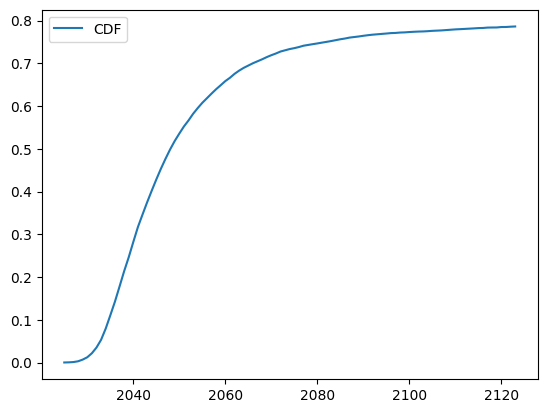

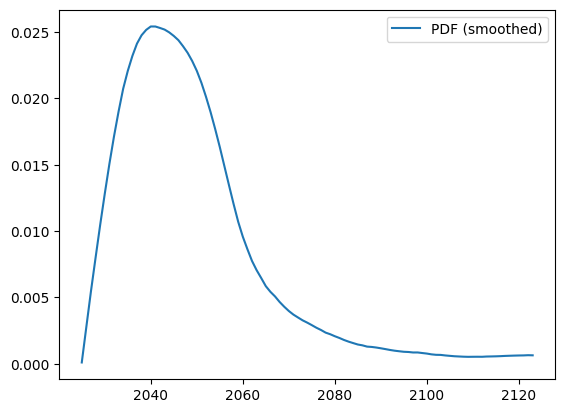

In [19]:
print('4E. When TAI?')
print('-')

yrs = bayes.bayesnet(define_event_lambda,
                     find=lambda e: e['final_state']['tai_year'],
                     raw=True,
                     n=VARS['RUNS'])
yrs = [VARS['MAX_YEAR'] + 1 if y is None else y for y in yrs]
print_tai_arrival_stats(yrs, VARS)

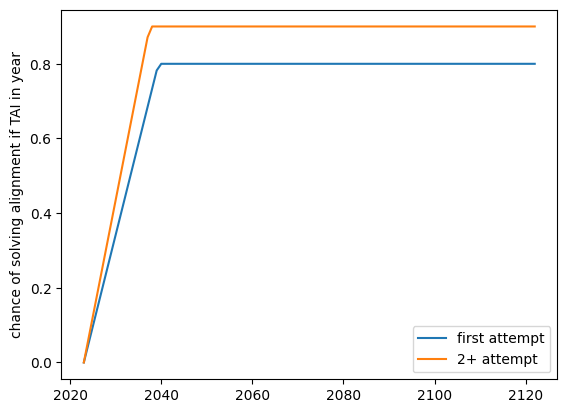

In [20]:
# TODO: p_alignment_deployment_safety_and_coordination(war=False, year=y - VARS['CURRENT_YEAR'], variables=VARS, first_attempt=True)
alignment_p = np.array([p_alignment_solved(year=y - VARS['CURRENT_YEAR'], first_attempt=True) for y in years])
alignment_p2 = np.array([p_alignment_solved(year=y - VARS['CURRENT_YEAR'], first_attempt=False) for y in years])
plt.plot(years, alignment_p, label='first attempt')
plt.plot(years, alignment_p2, label='2+ attempt')
plt.legend()
plt.ylabel('chance of solving alignment if TAI in year')
plt.show()


In [21]:
for y in list(years[:17]) + list(years[17::10]):
    str_ = 'Year: {} - chance of solving TAI alignment {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_p[y - VARS['CURRENT_YEAR']] * 100, 0),
                      round(alignment_p2[y - VARS['CURRENT_YEAR']] * 100, 0)))

Year: 2023 - chance of solving TAI alignment 0.0% (2nd attempt 0.0%)
Year: 2024 - chance of solving TAI alignment 5.0% (2nd attempt 6.0%)
Year: 2025 - chance of solving TAI alignment 10.0% (2nd attempt 12.0%)
Year: 2026 - chance of solving TAI alignment 15.0% (2nd attempt 19.0%)
Year: 2027 - chance of solving TAI alignment 20.0% (2nd attempt 25.0%)
Year: 2028 - chance of solving TAI alignment 24.0% (2nd attempt 31.0%)
Year: 2029 - chance of solving TAI alignment 29.0% (2nd attempt 37.0%)
Year: 2030 - chance of solving TAI alignment 34.0% (2nd attempt 44.0%)
Year: 2031 - chance of solving TAI alignment 39.0% (2nd attempt 50.0%)
Year: 2032 - chance of solving TAI alignment 44.0% (2nd attempt 56.0%)
Year: 2033 - chance of solving TAI alignment 49.0% (2nd attempt 62.0%)
Year: 2034 - chance of solving TAI alignment 54.0% (2nd attempt 68.0%)
Year: 2035 - chance of solving TAI alignment 59.0% (2nd attempt 75.0%)
Year: 2036 - chance of solving TAI alignment 64.0% (2nd attempt 81.0%)
Year: 2037

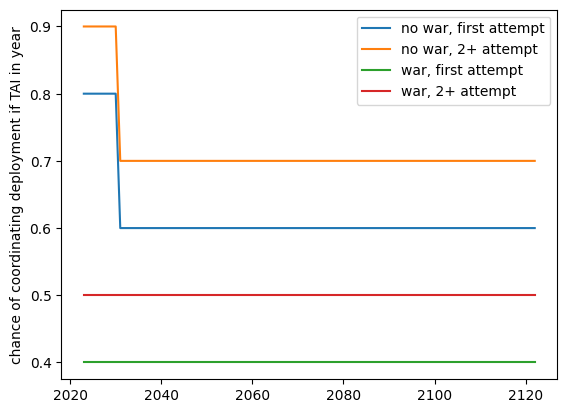

In [22]:
coordination_p = np.array([p_alignment_deployment_safety_and_coordination(year=y - VARS['CURRENT_YEAR'], war=False, variables=VARS, first_attempt=True) for y in years])
coordination_p2 = np.array([p_alignment_deployment_safety_and_coordination(year=y - VARS['CURRENT_YEAR'], war=False, variables=VARS, first_attempt=False) for y in years])
coordination_p_war = np.array([p_alignment_deployment_safety_and_coordination(year=y - VARS['CURRENT_YEAR'], war=True, variables=VARS, first_attempt=True) for y in years])
coordination_p2_war = np.array([p_alignment_deployment_safety_and_coordination(year=y - VARS['CURRENT_YEAR'], war=True, variables=VARS, first_attempt=False) for y in years])
plt.plot(years, coordination_p, label='no war, first attempt')
plt.plot(years, coordination_p2, label='no war, 2+ attempt')
plt.plot(years, coordination_p_war, label='war, first attempt')
plt.plot(years, coordination_p2_war, label='war, 2+ attempt')
plt.legend()
plt.ylabel('chance of coordinating deployment if TAI in year')
plt.show()


In [23]:
for y in list(years[:17]) + list(years[17::10]):
    str_ = 'Year: {} - chance of coordinating deployment no war -- {}% (2nd attempt {}%); war -- {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(coordination_p[y - VARS['CURRENT_YEAR']] * 100, 0),
                      round(coordination_p2[y - VARS['CURRENT_YEAR']] * 100, 0),
                      round(coordination_p_war[y - VARS['CURRENT_YEAR']] * 100, 0),
                      round(coordination_p2_war[y - VARS['CURRENT_YEAR']] * 100, 0)))

Year: 2023 - chance of coordinating deployment no war -- 80.0% (2nd attempt 90.0%); war -- 40.0% (2nd attempt 50.0%)
Year: 2024 - chance of coordinating deployment no war -- 80.0% (2nd attempt 90.0%); war -- 40.0% (2nd attempt 50.0%)
Year: 2025 - chance of coordinating deployment no war -- 80.0% (2nd attempt 90.0%); war -- 40.0% (2nd attempt 50.0%)
Year: 2026 - chance of coordinating deployment no war -- 80.0% (2nd attempt 90.0%); war -- 40.0% (2nd attempt 50.0%)
Year: 2027 - chance of coordinating deployment no war -- 80.0% (2nd attempt 90.0%); war -- 40.0% (2nd attempt 50.0%)
Year: 2028 - chance of coordinating deployment no war -- 80.0% (2nd attempt 90.0%); war -- 40.0% (2nd attempt 50.0%)
Year: 2029 - chance of coordinating deployment no war -- 80.0% (2nd attempt 90.0%); war -- 40.0% (2nd attempt 50.0%)
Year: 2030 - chance of coordinating deployment no war -- 80.0% (2nd attempt 90.0%); war -- 40.0% (2nd attempt 50.0%)
Year: 2031 - chance of coordinating deployment no war -- 60.0% (

In [24]:
print('AI X-Risk BY EOY year')

def find(y_c, category):
    return bayes.bayesnet(define_event_lambda,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=VARS['RUNS'])

for y_c in [2024, 2030, 2035, 2040, 2050, 2060, 2070, 2100]:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse') + find(y_c, 'xrisk_tai_misuse_extinction')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


AI X-Risk BY EOY year
2024 - 0.0% (Extinction: 0.0%, Bad TAI singleton: 0.0%, Subtly misaligned singleton: 0.0%, Misuse singleton: 0.0%)
2030 - 1.3% (Extinction: 0.1%, Bad TAI singleton: 1.0%, Subtly misaligned singleton: 0.1%, Misuse singleton: 0.1%)
2035 - 6.6% (Extinction: 0.5%, Bad TAI singleton: 4.6%, Subtly misaligned singleton: 0.8%, Misuse singleton: 0.6%)
2040 - 12.0% (Extinction: 0.8%, Bad TAI singleton: 7.5%, Subtly misaligned singleton: 2.5%, Misuse singleton: 1.2%)
2050 - 18.4% (Extinction: 1.0%, Bad TAI singleton: 10.1%, Subtly misaligned singleton: 4.7%, Misuse singleton: 2.6%)
2060 - 21.7% (Extinction: 1.1%, Bad TAI singleton: 11.5%, Subtly misaligned singleton: 5.9%, Misuse singleton: 3.3%)
2070 - 23.2% (Extinction: 1.2%, Bad TAI singleton: 12.0%, Subtly misaligned singleton: 6.4%, Misuse singleton: 3.6%)
2100 - 24.7% (Extinction: 1.2%, Bad TAI singleton: 12.6%, Subtly misaligned singleton: 6.9%, Misuse singleton: 4.0%)


In [25]:
print('Chance of successfully aligning TAI by EOY year')
for y_c in [2024, 2030, 2050, 2070, 2100]:
    r = bayes.bayesnet(define_event_lambda,
                       find=lambda e: 'aligned_tai' in e['collectors'][y_c]['category'],
                       n=VARS['RUNS'])
    r1 = bayes.bayesnet(define_event_lambda,
                        find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai_ends_time_of_perils',
                        n=VARS['RUNS'])
    r2 = bayes.bayesnet(define_event_lambda,
                        find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai_does_not_end_time_of_perils',
                        n=VARS['RUNS'])
    print('{} - {}% ({}% ends time of perils, {}% does not)'.format(y_c,
                                                                    round(r * 100, 2),
                                                                    round(r1 * 100, 2),
                                                                    round(r2 * 100, 2)))
    

Chance of successfully aligning TAI by EOY year
2024 - 0.01% (0.0% ends time of perils, 0.0% does not)
2030 - 2.08% (0.13% ends time of perils, 0.76% does not)
2050 - 52.65% (7.11% ends time of perils, 29.7% does not)
2070 - 68.64% (9.22% ends time of perils, 39.86% does not)
2100 - 73.22% (9.89% ends time of perils, 42.66% does not)


In [26]:
print('Cumulative Total X-Risk (including non-extinction x-risks and "ok but not great" x-risks)')

def find(y_c, category):
    return bayes.bayesnet(define_event_lambda,
                          find=lambda e: ('xrisk' in e['collectors'][y_c]['category']) and (category in e['collectors'][y_c]['category']),
                          n=VARS['RUNS'])

for y_c in [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2032, 2035, 2040, 2045, 2050, 2060, 2070, 2100]:
    ai = find(y_c, 'tai')
    nukes = find(y_c, 'nukes')
    unknown = find(y_c, 'unknown')
    nano = find(y_c, 'nanotech')
    natural = find(y_c, 'supervolcano')
    bio = find(y_c, 'bio')

    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round((ai + nukes + bio + nano + unknown) * 100, 2),
                     round(ai * 100, 2),
                     round(nukes * 100, 3),
                     round(bio * 100, 3),
                     round(nano * 100, 3),
                     round(natural * 100, 3),
                     round(unknown * 100, 3)))


Cumulative Total X-Risk (including non-extinction x-risks and "ok but not great" x-risks)
2023 - 0.0% (AI: 0.0%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2024 - 0.01% (AI: 0.01%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2025 - 0.02% (AI: 0.02%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2026 - 0.1% (AI: 0.09%, Nukes: 0.0%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2027 - 0.22% (AI: 0.21%, Nukes: 0.0%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2028 - 0.44% (AI: 0.41%, Nukes: 0.02%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2029 - 0.76% (AI: 0.72%, Nukes: 0.02%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.01%)
2030 - 1.32% (AI: 1.28%, Nukes: 0.02%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.01%)
2032 - 3.0% (AI: 2.94%, Nukes: 0.04%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.01%)
2035 - 6.64% (AI: 6.56%, Nukes: 0.06%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.01%)
2040 - 1

In [27]:
print('Cumulative Total Extinction Risk')

def find(y_c, category):
    return bayes.bayesnet(define_event_lambda,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=VARS['RUNS'])

for y_c in [2030, 2050, 2100]:
    ai = find(y_c, 'xrisk_full_unaligned_tai_extinction') + find(y_c, 'xrisk_tai_misuse_extinction')
    nukes_war = find(y_c, 'xrisk_nukes_war')
    nukes_accident = find(y_c, 'xrisk_nukes_accident')
    unknown = find(y_c, 'xrisk_unknown_unknown')
    bio_war = find(y_c, 'xrisk_bio_war')
    bio_accident = find(y_c, 'xrisk_bio_accident')
    bio_nonstate = find(y_c, 'xrisk_bio_nonstate')
    nanotech = find(y_c, 'xrisk_nanotech')
    supervolcano = find(y_c, 'xrisk_supervolcano')
    
    r = bayes.bayesnet(define_event_lambda,
                       find=lambda e: e['collectors'][y_c]['category'] in extinctions,
                       n=VARS['RUNS'])
    
    out = '{} - {}% (AI: {}%, Nukes: {}% (War: {}% Accident: {}%), Bio: {}% (War: {}%, Accident: {}%, Nonstate: {}%), Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round(r * 100, 2),
                     round(ai * 100, 2),
                     round((nukes_war + nukes_accident) * 100, 3),
                     round(nukes_war * 100, 3),
                     round(nukes_accident * 100, 3),
                     round((bio_war + bio_accident + bio_nonstate) * 100, 3),
                     round(bio_war * 100, 3),
                     round(bio_accident * 100, 3),
                     round(bio_nonstate * 100, 3),
                     round(nanotech * 100, 3),
                     round(supervolcano * 100, 3),
                     round(unknown * 100, 3)))
        

Cumulative Total Extinction Risk
2030 - 0.16% (AI: 0.12%, Nukes: 0.02% (War: 0.02% Accident: 0.0%), Bio: 0.01% (War: 0.0%, Accident: 0.01%, Nonstate: 0.0%), Nano: 0.0%, Natural: 0.0%, Other: 0.01%)
2050 - 1.32% (AI: 1.16%, Nukes: 0.12% (War: 0.06% Accident: 0.06%), Bio: 0.01% (War: 0.0%, Accident: 0.01%, Nonstate: 0.0%), Nano: 0.0%, Natural: 0.0%, Other: 0.03%)
2100 - 1.82% (AI: 1.46%, Nukes: 0.26% (War: 0.13% Accident: 0.13%), Bio: 0.01% (War: 0.0%, Accident: 0.01%, Nonstate: 0.0%), Nano: 0.04%, Natural: 0.0%, Other: 0.05%)


In [28]:
# https://www.metaculus.com/questions/1493/global-population-decline-10-by-2100/
print('Cumulative Total Catastrophe Risk (defined as 10%+ death)')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event_lambda,
                       find=lambda e: (e['collectors'][y_c]['catastrophe'] != []) or (e['collectors'][y_c]['category'] in extinctions),
                       n=VARS['RUNS'])
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

Cumulative Total Catastrophe Risk (defined as 10%+ death)
2030 - 3.01%
2050 - 20.13%
2100 - 29.24%


In [29]:
print('Cumulative Total *Actively Bad* Future X-Risk (including non-extinction risks but excluding subtle AI misalignment)')

def find(y_c, category):
    return bayes.bayesnet(define_event_lambda,
                          find=lambda e: ('xrisk' in e['collectors'][y_c]['category']) and (category in e['collectors'][y_c]['category']),
                          n=VARS['RUNS'])

for y_c in [2023, 2025, 2030, 2035, 2040, 2045, 2050, 2060, 2070, 2100]:
    ai = find(y_c, 'tai')
    ai_subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    nukes = find(y_c, 'nukes')
    unknown = find(y_c, 'unknown')
    nano = find(y_c, 'nanotech')
    natural = find(y_c, 'supervolcano')
    bio = find(y_c, 'bio')

    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round((ai - ai_subtle_misalignment + nukes + bio + nano + unknown) * 100, 2),
                     round((ai - ai_subtle_misalignment) * 100, 2),
                     round(nukes * 100, 3),
                     round(bio * 100, 3),
                     round(nano * 100, 3),
                     round(natural * 100, 3),
                     round(unknown * 100, 3)))


Cumulative Total *Actively Bad* Future X-Risk (including non-extinction risks but excluding subtle AI misalignment)
2023 - 0.0% (AI: 0.0%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2025 - 0.02% (AI: 0.02%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2030 - 1.25% (AI: 1.21%, Nukes: 0.02%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.01%)
2035 - 5.8% (AI: 5.72%, Nukes: 0.06%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.01%)
2040 - 9.6% (AI: 9.51%, Nukes: 0.06%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.02%)
2045 - 12.06% (AI: 11.92%, Nukes: 0.11%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.02%)
2050 - 13.87% (AI: 13.71%, Nukes: 0.12%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.03%)
2060 - 16.09% (AI: 15.88%, Nukes: 0.17%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.03%)
2070 - 17.07% (AI: 16.83%, Nukes: 0.19%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.04%)
2100 - 18.22% (AI: 17.86%, Nukes: 0.26%, Bio: 0.01%, Nano:

## Appendix

In [30]:
trigger_found = False
i = 0
trigger_found = False
while not trigger_found:
    print('.', end='')
    y_c = years[i]
    ai = find(y_c, 'tai')
    nukes = find(y_c, 'nukes')
    unknown = find(y_c, 'unknown')
    nano = find(y_c, 'nanotech')
    natural = find(y_c, 'supervolcano')
    bio = find(y_c, 'bio')
    xrisk = ai + nukes + bio + nano + unknown
    if xrisk > 0.05:
        trigger_found = True
        y_c -= (xrisk - 0.05)/0.05
    i += 1

print('')
if not trigger_found:
    y_c = '>2100'
else:
    y_c = dt.datetime.strftime(dt.datetime.now() + dt.timedelta(days=(y_c - 2023) * 365.24), '%Y %b %d')
    
print('5% X-Risk By {}'.format(y_c))

............
5% X-Risk By 2034 Apr 29


In [31]:
print('Total X-Risk IN THAT SPECIFIC YEAR (non-cumulative) (including non-extinction x-risks)')

ai = np.diff(np.array([find(y, 'tai') for y in tqdm(range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR']))]))
nukes = np.diff(np.array([find(y, 'nukes') for y in tqdm(range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR']))]))
unknown = np.diff(np.array([find(y, 'unknown') for y in tqdm(range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR']))]))
nano = np.diff(np.array([find(y, 'nanotech') for y in tqdm(range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR']))]))
natural = np.diff(np.array([find(y, 'supervolcano') for y in tqdm(range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR']))]))
bio = np.diff(np.array([find(y, 'bio') for y in tqdm(range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR']))]))

for y_c in range(VARS['MAX_YEAR'] - VARS['CURRENT_YEAR'] - 1):
    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c + VARS['CURRENT_YEAR'],
                     round((ai[y_c] + nukes[y_c] + bio[y_c] + nano[y_c] + unknown[y_c]) * 100, 8),
                     round(ai[y_c] * 100, 8),
                     round(nukes[y_c] * 100, 8),
                     round(bio[y_c] * 100, 8),
                     round(nano[y_c] * 100, 8),
                     round(natural[y_c] * 100, 8),
                     round(unknown[y_c] * 100, 8)))

Total X-Risk IN THAT SPECIFIC YEAR (non-cumulative) (including non-extinction x-risks)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 102.42it/s]

2023 - 0.01% (AI: 0.01%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2024 - 0.01% (AI: 0.01%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2025 - 0.08% (AI: 0.07%, Nukes: 0.0%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2026 - 0.12% (AI: 0.12%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2027 - 0.22% (AI: 0.2%, Nukes: 0.02%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2028 - 0.32% (AI: 0.31%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.01%)
2029 - 0.56% (AI: 0.56%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2030 - 0.79% (AI: 0.77%, Nukes: 0.02%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2031 - 0.89% (AI: 0.89%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2032 - 1.11% (AI: 1.1%, Nukes: 0.01%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2033 - 1.3% (AI: 1.29%, Nukes: 0.01%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2034 - 1.23% (AI: 

In [32]:
xrisk_df = pd.DataFrame({'year': range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR'] - 1),
                         'ai': ai,
                         'nukes': nukes,
                         'unknown': unknown,
                         'nano': nano,
                         'natural': natural,
                         'bio': bio})
xrisk_df['total'] = xrisk_df['ai'] + xrisk_df['nukes'] + xrisk_df['unknown'] + xrisk_df['nano'] + xrisk_df['natural'] + xrisk_df['bio']
xrisk_df.to_csv('caches/xrisk_df.csv', index=False)
xrisk_df

,year,ai,nukes,unknown,nano,natural,bio,total
0,2023,0.0001,0.0000,0.0000,0.0,0.0,0.0000,0.0001
1,2024,0.0001,0.0000,0.0000,0.0,0.0,0.0000,0.0001
2,2025,0.0007,0.0000,0.0000,0.0,0.0,0.0001,0.0008
3,2026,0.0012,0.0000,0.0000,0.0,0.0,0.0000,0.0012
4,2027,0.0020,0.0002,0.0000,0.0,0.0,0.0000,0.0022
...,...,...,...,...,...,...,...,...
94,2117,0.0000,0.0000,0.0000,0.0,0.0,0.0001,0.0001
95,2118,0.0003,0.0000,0.0000,0.0,0.0,0.0000,0.0003
96,2119,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000
97,2120,0.0004,0.0000,0.0000,0.0,0.0,0.0000,0.0004


In [33]:
print('Total X-Risk OR catastrophe by EOY year')

for y_c in [2024, 2030, 2050, 2070, 2100]:
    r = bayes.bayesnet(define_event_lambda,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] or e['collectors'][y_c]['catastrophe'] != [],
                       n=VARS['RUNS'])
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


Total X-Risk OR catastrophe by EOY year
2024 - 0.39%
2030 - 3.08%
2050 - 24.71%
2070 - 31.29%
2100 - 35.63%


In [34]:
print('Total X-Risk AND catastrophe by EOY year')

for y_c in [2024, 2030, 2050, 2070, 2100]:
    r = bayes.bayesnet(define_event_lambda,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] and e['collectors'][y_c]['catastrophe'] != [],
                       n=VARS['RUNS'])
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


Total X-Risk AND catastrophe by EOY year
2024 - 0.01%
2030 - 1.23%
2050 - 13.76%
2070 - 17.08%
2100 - 18.26%


In [35]:
# https://forum.effectivealtruism.org/posts/nYgw4FNpHf9bmJGEi/forecasting-thread-how-does-ai-risk-level-vary-based-on

def generate_conditional(y_low, y_high):
    def fn(e):
        if e['final_state']['tai_year'] is None:
            return False
        elif e['final_state']['tai_year'] < y_low:
            return False
        elif e['final_state']['tai_year'] > y_high:
            return False
        else:
            return True
    return fn
    

def find(y_low, y_high, category):
    return bayes.bayesnet(define_event_lambda,
                          find=lambda e: e['collectors'][VARS['MAX_YEAR'] - 1 if y_high >= VARS['MAX_YEAR'] else y_high]['category'] == category,
                          conditional_on=generate_conditional(y_low, y_high),
                          n=VARS['RUNS'])


for y_c in [[2022, 2024], [2024, 2029], [2029, 2039], [2039, 2059], [2059, VARS['MAX_YEAR'] - 1], [2022, 2070]]:
    print('AI X-Risk conditional on AGI beween beginning of {} and end of {}'.format(y_c[0] + 1, y_c[1]))
    extinction = find(y_c[0], y_c[1], 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c[0], y_c[1], 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c[0], y_c[1], 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c[0], y_c[1], 'xrisk_tai_misuse')
    out = '{}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))
    print('-')


AI X-Risk conditional on AGI beween beginning of 2023 and end of 2024
100.0% (Extinction: 0.0%, Bad TAI singleton: 100.0%, Subtly misaligned singleton: 0.0%, Misuse singleton: 0.0%)
-
AI X-Risk conditional on AGI beween beginning of 2025 and end of 2029
58.5% (Extinction: 5.7%, Bad TAI singleton: 48.0%, Subtly misaligned singleton: 1.6%, Misuse singleton: 3.3%)
-
AI X-Risk conditional on AGI beween beginning of 2030 and end of 2039
38.6% (Extinction: 2.5%, Bad TAI singleton: 24.5%, Subtly misaligned singleton: 7.8%, Misuse singleton: 3.9%)
-
AI X-Risk conditional on AGI beween beginning of 2040 and end of 2059
27.8% (Extinction: 1.0%, Bad TAI singleton: 11.7%, Subtly misaligned singleton: 9.8%, Misuse singleton: 5.2%)
-
AI X-Risk conditional on AGI beween beginning of 2060 and end of 2122
27.7% (Extinction: 1.1%, Bad TAI singleton: 9.8%, Subtly misaligned singleton: 9.5%, Misuse singleton: 7.2%)
-
AI X-Risk conditional on AGI beween beginning of 2023 and end of 2070
31.8% (Extinction: 

In [36]:
print('Have we seen the following wars by EOY year?')

def print_wars(wars):
    bs = [[w['belligerents'] if w != [] else [] for w in ws] for ws in wars]
    bs = Counter([' '.join(sorted(b)) for b in bs])    
    bs = dict([(k, round(v / VARS['RUNS'] * 100, 3)) for k, v in bs.items()])
    bs = sorted(bs.items(), key=lambda x: x[1], reverse=True)
    for war in ['US/China', 'US/Russia', 'Other']:
        print('{}: {}%'.format(war, round(sum([b[1] if war in b[0] else 0 for b in bs]), 1)))

for y_c in [2023, 2026, 2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    print_wars([c[y_c]['wars'] for c in collectors])
    print('-')
    print('-')

Have we seen the following wars by EOY year?
## 2023 ##
US/China: 0.6%
US/Russia: 2.2%
Other: 0.1%
-
-
## 2026 ##
US/China: 6.5%
US/Russia: 5.0%
Other: 0.2%
-
-
## 2030 ##
US/China: 15.5%
US/Russia: 5.9%
Other: 0.4%
-
-
## 2050 ##
US/China: 24.7%
US/Russia: 9.1%
Other: 2.5%
-
-
## 2070 ##
US/China: 27.0%
US/Russia: 11.8%
Other: 5.6%
-
-
## 2100 ##
US/China: 30.4%
US/Russia: 15.6%
Other: 9.6%
-
-


In [37]:
print('Offensive nuclear weapon use (1+ fatality) by EOY year?')

def p_nuke_used_by(y_c):
    return bayes.bayesnet(define_event_lambda,
                          find=lambda e: e['collectors'][y_c]['nuclear_weapon_used'],
                          n=VARS['RUNS'])

for y_c in [2030, 2050, 2070, 2100]:
    print('{}: {}%'.format(y_c, round(p_nuke_used_by(y_c) * 100, 2)))

Offensive nuclear weapon use (1+ fatality) by EOY year?
2030: 7.67%
2050: 17.57%
2070: 22.6%
2100: 29.32%


In [38]:
print('Detail on war states')

def print_wars(wars):
    bs = [[w['belligerents'] if w != [] else [] for w in ws] for ws in wars]
    bs = Counter([' '.join(sorted(b)) for b in bs])    
    bs = dict([(k, round(v / VARS['RUNS'] * 100, 3)) for k, v in bs.items()])
    bs = sorted(bs.items(), key=lambda x: x[1], reverse=True)
    return bs

for y_c in [2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    pprint(print_wars([c[y_c]['wars'] for c in collectors]))
    print('-')
    print('-')

Detail on war states
## 2030 ##
[('', 78.32),
 ('US/China', 15.36),
 ('US/Russia', 5.75),
 ('Other', 0.38),
 ('US/China US/Russia', 0.11),
 ('US/China US/China', 0.06),
 ('Other US/China', 0.01),
 ('US/China US/China US/Russia', 0.01)]
-
-
## 2050 ##
[('', 64.31),
 ('US/China', 23.57),
 ('US/Russia', 8.57),
 ('Other', 2.31),
 ('US/China US/China', 0.51),
 ('US/China US/Russia', 0.46),
 ('Other US/China', 0.16),
 ('US/Russia US/Russia', 0.05),
 ('Other US/Russia', 0.04),
 ('US/China US/China US/China US/China', 0.01),
 ('US/China US/China US/Russia', 0.01)]
-
-
## 2070 ##
[('', 57.38),
 ('US/China', 24.56),
 ('US/Russia', 10.57),
 ('Other', 4.71),
 ('US/China US/China', 0.84),
 ('US/China US/Russia', 0.81),
 ('Other US/China', 0.65),
 ('US/Russia US/Russia', 0.21),
 ('Other US/Russia', 0.15),
 ('US/China US/China US/China', 0.05),
 ('Other Other', 0.03),
 ('US/China US/China US/China US/China US/China', 0.01),
 ('US/China US/China US/China US/China', 0.01),
 ('US/China US/China US/Russi

In [39]:
print('Detail on # of Wars At Year')

for y_c in [2030, 2050, 2070, 2100]:
    print('## # of wars as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['wars']) for c in collectors]))
    print('-')
    print('-')


Detail on # of Wars At Year
## # of wars as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of wars as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of wars as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of wars as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 2.0,
 99: 2.0}
-
-


In [40]:
print('Detail on War Length States At Year')

def print_wars(y, wars):
    bs = [[(w['end_year'] - w['start_year'] if w['end_year'] < y else y - w['start_year']) if w != [] else 0 for w in ws] for ws in wars]
    bs = [round(sum(b) / (y - VARS['CURRENT_YEAR']) * 100, 1) for b in bs]
    return bs

for y_c in [2030, 2050, 2070, 2100]:
    print('## Percent of time in war as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles(print_wars(y_c, [c[y_c]['wars'] for c in collectors])))
    print('-')
    print('-')

Detail on War Length States At Year
## Percent of time in war as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 57.1,
 95: 71.4,
 99: 100.0}
-
-
## Percent of time in war as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 11.1,
 80: 29.6,
 90: 59.3,
 95: 74.1,
 99: 96.3}
-
-
## Percent of time in war as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 4.3,
 70: 12.8,
 80: 21.3,
 90: 40.4,
 95: 59.6,
 99: 91.5}
-
-
## Percent of time in war as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 1.3,
 60: 6.5,
 70: 11.7,
 80: 18.2,
 90: 31.2,
 95: 44.2,
 99: 81.8}
-
-


In [41]:
def print_states(states):
    c = Counter(states)
    c = dict([(k, round(v / VARS['RUNS'] * 100, 3)) for k, v in c.items()])
    for k in c.keys():
        if k not in STATES:
            raise ValueError('State {} not in `STATES`'.format(k))
    for state in STATES:
        if not c.get(state):
            c[state] = 0.0
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    return c


print('Detail on World State At Year')
for y_c in [2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c)) 
    pprint(print_states([c[y_c]['category'] for c in collectors]))
    print('-')
    print('-')

Detail on World State At Year
## 2030 ##
[('boring', 97.79),
 ('xrisk_full_unaligned_tai_singleton', 1.0),
 ('aligned_tai_does_not_end_time_of_perils', 0.76),
 ('aligned_tai_ends_time_of_perils', 0.13),
 ('xrisk_full_unaligned_tai_extinction', 0.12),
 ('xrisk_tai_misuse', 0.09),
 ('xrisk_subtly_unaligned_tai', 0.07),
 ('xrisk_nukes_war', 0.02),
 ('xrisk_unknown_unknown', 0.01),
 ('xrisk_bio_accident', 0.01),
 ('xrisk_tai_misuse_extinction', 0.0),
 ('aligned_tai', 0.0),
 ('xrisk_nanotech', 0.0),
 ('xrisk_nukes_accident', 0.0),
 ('xrisk_bio_war', 0.0),
 ('xrisk_bio_nonstate', 0.0),
 ('xrisk_supervolcano', 0.0)]
-
-
## 2050 ##
[('boring', 44.62),
 ('aligned_tai_does_not_end_time_of_perils', 29.7),
 ('xrisk_full_unaligned_tai_singleton', 10.11),
 ('aligned_tai_ends_time_of_perils', 7.11),
 ('xrisk_subtly_unaligned_tai', 4.7),
 ('xrisk_tai_misuse', 2.44),
 ('xrisk_full_unaligned_tai_extinction', 1.03),
 ('xrisk_tai_misuse_extinction', 0.13),
 ('xrisk_nukes_accident', 0.06),
 ('xrisk_nukes_w

In [42]:
print('Detail on Catastrophe States At Year')

def print_catastrophe(catastrophes):
    c = Counter([' '.join(sorted(c)) for c in catastrophes])
    c = dict([(k, round(v / VARS['RUNS'] * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')

Detail on Catastrophe States At Year
## 2023 ##
[('', 99.84)]
-
-
## 2030 ##
[('', 97.01),
 ('xrisk_full_unaligned_tai_singleton', 1.0),
 ('engineered_pathogen', 0.54),
 ('natural_pathogen', 0.4),
 ('nukes_war', 0.4),
 ('nukes_accident', 0.26),
 ('xrisk_full_unaligned_tai_extinction', 0.12),
 ('averting_misaligned_tai', 0.1)]
-
-
## 2050 ##
[('', 80.1),
 ('xrisk_full_unaligned_tai_singleton', 9.99),
 ('xrisk_tai_misuse', 2.37),
 ('engineered_pathogen', 1.45),
 ('nukes_war', 1.33),
 ('xrisk_full_unaligned_tai_extinction', 1.03),
 ('averting_misaligned_tai', 1.02),
 ('natural_pathogen', 1.02),
 ('nukes_accident', 0.97),
 ('averting_intentional_tai', 0.19)]
-
-
## 2070 ##
[('', 75.05),
 ('xrisk_full_unaligned_tai_singleton', 11.76),
 ('xrisk_tai_misuse', 3.24),
 ('engineered_pathogen', 2.06),
 ('nukes_war', 1.57),
 ('natural_pathogen', 1.45),
 ('xrisk_full_unaligned_tai_extinction', 1.2),
 ('nukes_accident', 1.18),
 ('averting_misaligned_tai', 1.15),
 ('averting_intentional_tai', 0.25),
 

In [43]:
print('Detail on # of Catastrophes At Year')

for y_c in [2030, 2050, 2070, 2100]:
    print('## # of catastrophes as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['catastrophe']) for c in collectors]))
    print('-')
    print('-')

Detail on # of Catastrophes At Year
## # of catastrophes as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 95: 0.0,
 99: 1.0}
-
-
## # of catastrophes as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of catastrophes as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of catastrophes as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-


In [44]:
print('Detail on *First* Catastrophe State At Year')

def print_catastrophe_first(catastrophes):
    c = Counter([c[0] if len(c) > 0 else '' for c in catastrophes])
    c = dict([(k, round(v / VARS['RUNS'] * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe_first([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')

Detail on *First* Catastrophe State At Year
## 2023 ##
[('', 99.84)]
-
-
## 2030 ##
[('', 97.01),
 ('xrisk_full_unaligned_tai_singleton', 1.0),
 ('engineered_pathogen', 0.56),
 ('nukes_war', 0.42),
 ('natural_pathogen', 0.4),
 ('nukes_accident', 0.27),
 ('xrisk_full_unaligned_tai_extinction', 0.12),
 ('averting_misaligned_tai', 0.11)]
-
-
## 2050 ##
[('', 80.1),
 ('xrisk_full_unaligned_tai_singleton', 9.99),
 ('xrisk_tai_misuse', 2.37),
 ('engineered_pathogen', 1.55),
 ('nukes_war', 1.51),
 ('natural_pathogen', 1.13),
 ('nukes_accident', 1.05),
 ('averting_misaligned_tai', 1.04),
 ('xrisk_full_unaligned_tai_extinction', 1.03),
 ('averting_intentional_tai', 0.2)]
-
-
## 2070 ##
[('', 75.05),
 ('xrisk_full_unaligned_tai_singleton', 11.76),
 ('xrisk_tai_misuse', 3.24),
 ('engineered_pathogen', 2.26),
 ('nukes_war', 1.97),
 ('natural_pathogen', 1.61),
 ('nukes_accident', 1.37),
 ('averting_misaligned_tai', 1.24),
 ('xrisk_full_unaligned_tai_extinction', 1.2),
 ('averting_intentional_tai', 

In [45]:
print('Detail on Double Catastrophe X-Risks')

def print_double_catastrophes(catastrophes):
    c = Counter(['' if c is None else c for c in catastrophes])
    c = dict([(k, round(v / VARS['RUNS'] * 100, 3)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    # c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    pprint(print_double_catastrophes([c[y_c]['double_catastrophe_xrisk'] for c in collectors]))
    print('-')
    print('-')

Detail on Double Catastrophe X-Risks
## 2030 ##
[('', 100.0)]
-
-
## 2050 ##
[('', 99.99), ('nukes_war->nukes_accident', 0.01)]
-
-
## 2070 ##
[('', 99.99), ('nukes_war->nukes_accident', 0.01)]
-
-
## 2100 ##
[('', 99.97),
 ('nukes_war->nukes_accident', 0.02),
 ('engineered_pathogen->nukes_war', 0.01)]
-
-
